# Calculating Monthly Overdose deaths from CDC data
Author: Samir Akre
Last Updated: Jan 3 2021

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.load_data as ld
import src.defilter_data as dd
import src.estimate_error as ee
import importlib
import scipy.stats as stats

## Import and clean data
- 'predicted_val' column is 12-month rolling sum of monthly overdose deaths
- 'Deaths' column are the imputed monthly overdose deaths

In [2]:
importlib.reload(dd)
importlib.reload(ld)
data = ld.load_data()
data

,timestamp,location,predicted_val,Deaths
64,2015-01-01,Alabama,742,65.0
63,2015-02-01,Alabama,749,60.0
62,2015-03-01,Alabama,758,79.0
61,2015-04-01,Alabama,764,69.0
60,2015-05-01,Alabama,782,74.0
...,...,...,...,...
3254,2020-01-01,Wyoming,78,NaN
3253,2020-02-01,Wyoming,80,NaN
3252,2020-03-01,Wyoming,81,NaN
3251,2020-04-01,Wyoming,83,NaN


## Impute/Predict 2020 monthly data
- 11 months of monthly death data used to "unroll" to 12 month rolling sum reported for 2020 months

In [3]:
k = 12 # 12 month rolling sum
time_filt = data[data.timestamp >= pd.to_datetime('2019-01-01')]
time_filt['raw_predicted_val'] = np.nan
for loc in time_filt['location'].unique():
    truth = time_filt.loc[time_filt.location == loc, 'Deaths'].values
    pred = dd.defilter(time_filt.loc[data.location == loc, 'predicted_val'].iloc[11:].values, k, truth[:11])
    time_filt.loc[time_filt.location == loc, 'raw_predicted_val'] = pred
time_filt['raw_predicted_val'] = time_filt['raw_predicted_val'].astype(float)

/Users/akre96/Code/cdc_overdose/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akre96/Code/cdc_overdose/venv/lib/python3.7/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/akre96/Code/cdc_overdose/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyW

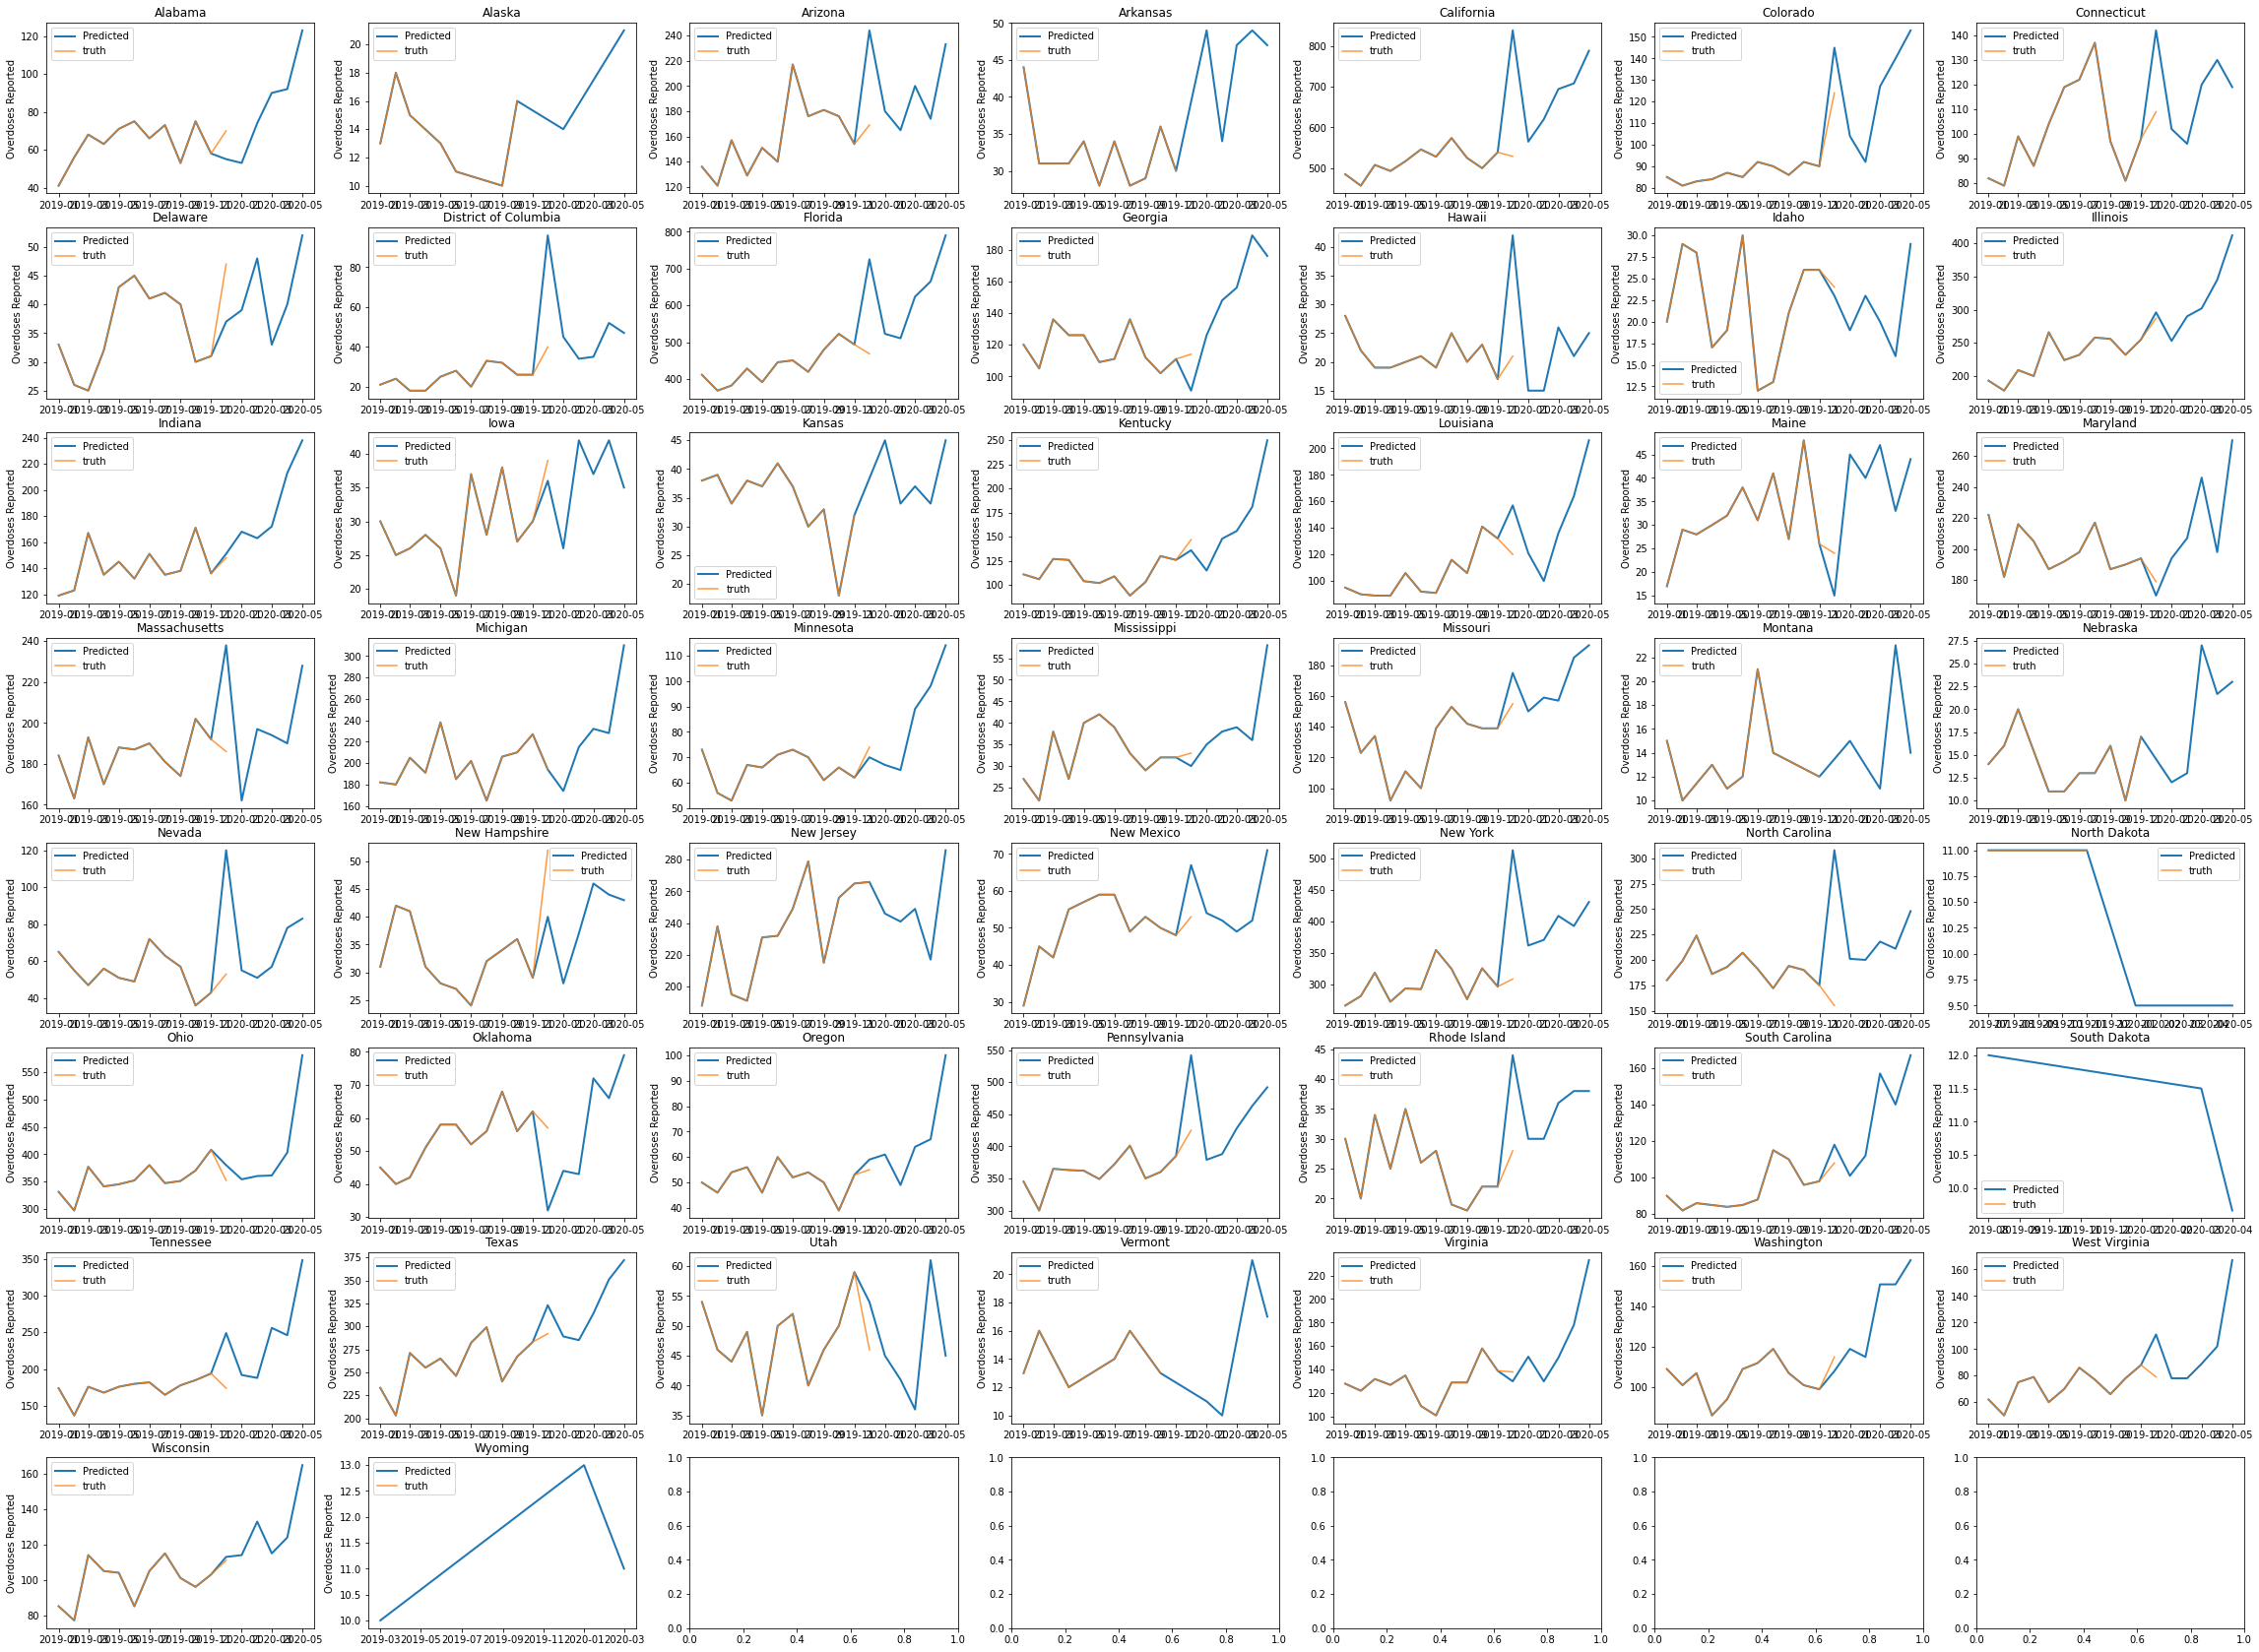

In [4]:
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(40,30))
i = 0
for loc, loc_data in time_filt.groupby('location'):
    ax=axes.flatten()[i]
    filt_data = loc_data.copy()
    # Hides values less than 10 from plot
    for col in ['raw_predicted_val', 'Deaths']:
        filt_data.loc[filt_data[col] <= 9] = np.nan
    sns.lineplot(
        x='timestamp',
        y='raw_predicted_val',
        data=filt_data,
        label='Predicted',
        markers=True,
        lw=2,
        ax=ax
    )
    sns.lineplot(
        x='timestamp',
        y='Deaths',
        data=filt_data,
        label='truth',
        markers=True,
        alpha=.8,
        ax=ax
    )
    ax.set_ylabel('Overdoses Reported')
    ax.set_title(loc)
    ax.set_xlabel('')
    i+=1

In [5]:
time_filt[[
    'location', 'Deaths', 'timestamp', 'raw_predicted_val'
]].to_csv('output/monthly_overdose_computed_m2.csv', index=False)

In [6]:
time_filt[time_filt.Deaths.isna()].groupby('timestamp').raw_predicted_val.sum()

timestamp
2020-01-01    6356.0
2020-02-01    6522.0
2020-03-01    7356.0
2020-04-01    7703.0
2020-05-01    9192.0
Name: raw_predicted_val, dtype: float64

# Error Analysis

## Testing rolling sum unrolling method

In [7]:
time = np.arange(0, 12*6)/12
truth = np.random.randint(0, 1000, size=time.shape)
truth = np.sin(time*2) + 1
cumTruth = pd.Series(truth).rolling(window=12).sum().values


<AxesSubplot:>

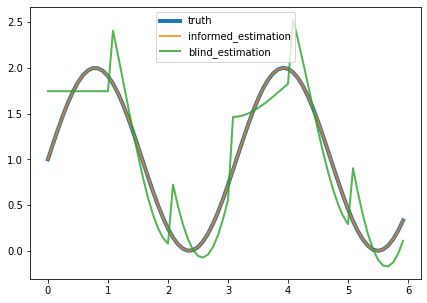

In [8]:
importlib.reload(dd)
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(
    x=time,
    y=truth,
    label='truth',
    lw=4,
    ax=ax
)
sns.lineplot(
    x=time,
    y=dd.defilter(cumTruth[11:], 12, truth[:11]),
    label='informed_estimation',
    lw=2,
    alpha=.8,
    ax=ax
)

sns.lineplot(
    x=time,
    y=dd.defilter(cumTruth[12:], 12),
    label='blind_estimation',
    lw=2,
    alpha=.8,
    ax=ax
)

## Discrepency in computed rolling sum of CDC monthly data vs reported rolling sum from CDC

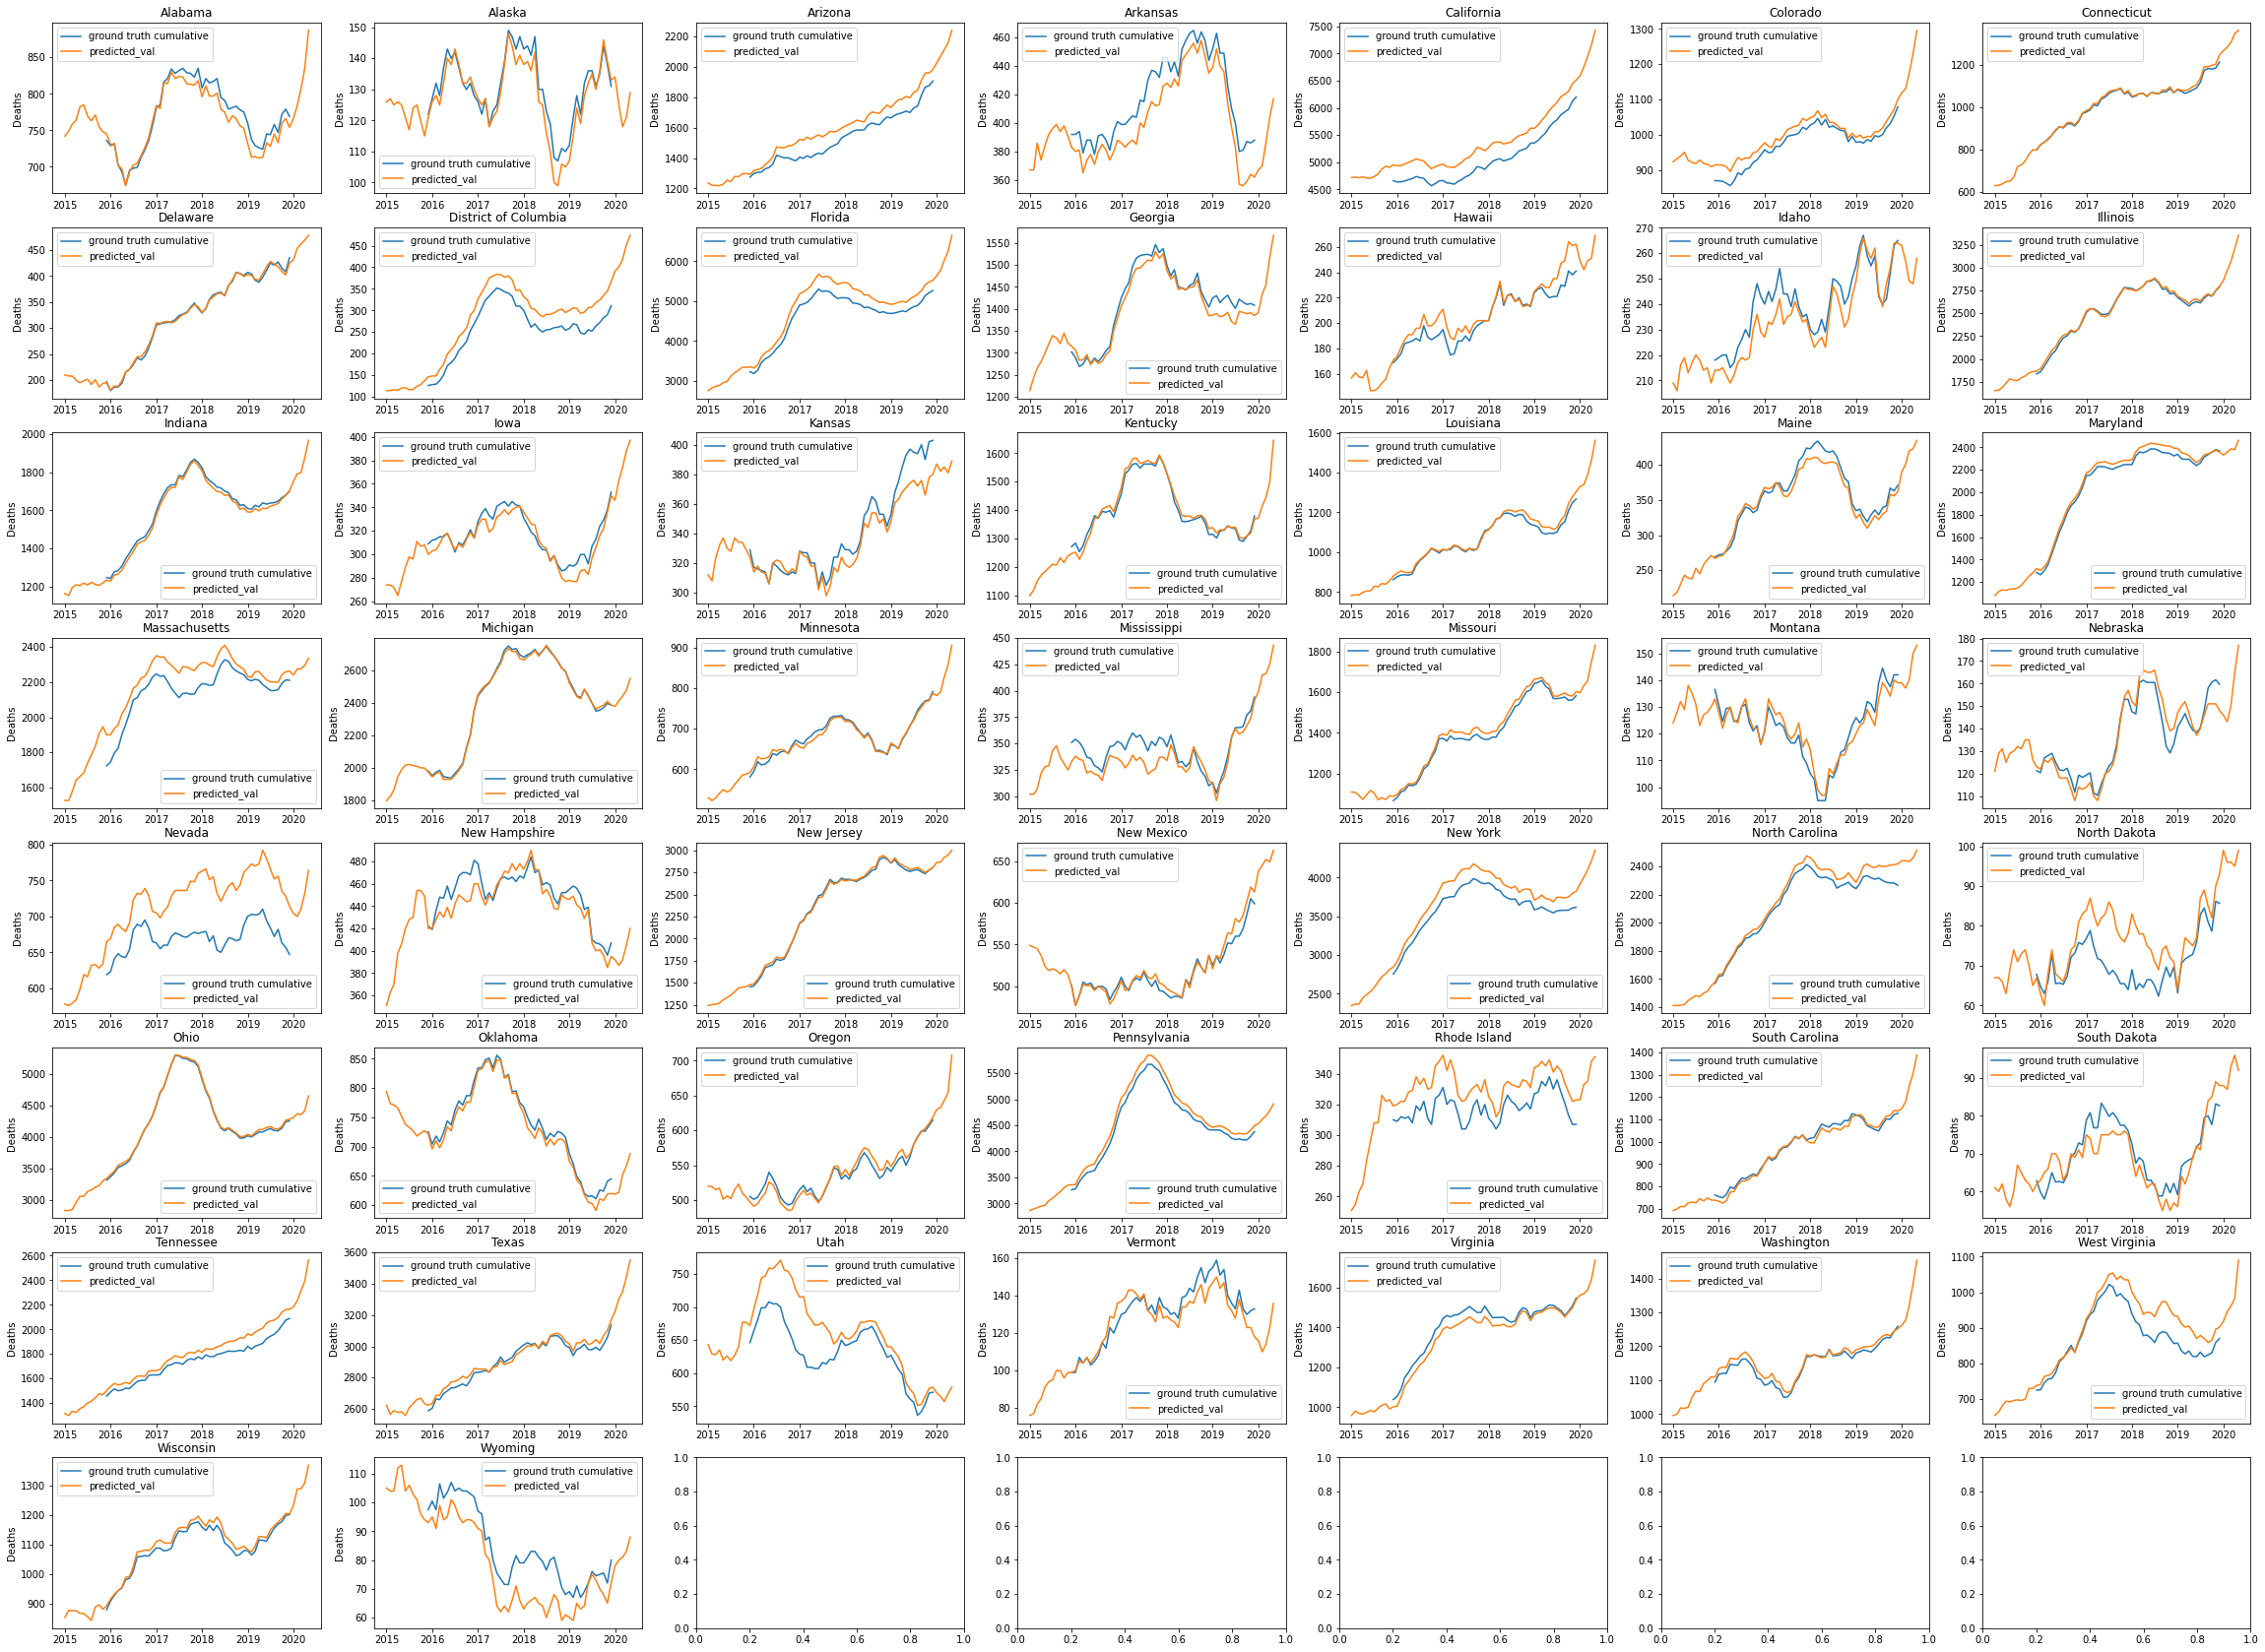

In [9]:
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(40,30))
i = 0
for loc, loc_data in data.groupby('location'):
    ax=axes.flatten()[i]
    int_loc = loc_data.loc[loc_data.Deaths != 'Suppressed']
    int_loc.Deaths = int_loc.Deaths.rolling(12).sum()
    sns.lineplot(
        y='Deaths',
        x='timestamp',
        data=int_loc,
        label='ground truth cumulative',
        ax=ax,
    )
    sns.lineplot(
        y='predicted_val',
        label='predicted_val',
        x='timestamp',
        data=int_loc,
        ax=ax
    )
    ax.vlines(loc_data.loc[loc_data.Deaths == 'Suppressed', 'timestamp'], *ax.get_ylim(), lw=1, alpha=.5, color='red')
    ax.set_title(loc)
    ax.set_xlabel('')

    i+=1


## Calculate prediction error at n-months out from 11 months of ground truth data used

In [10]:
importlib.reload(ee)
error_data = ee.calculate_error(data)
error_data.to_csv('output/full_error.csv', index=False)
error_data

,location,pred_timestamp,truth,error,pred,percent_error,month_out
0,Alabama,2015-12-01,51.0,-9.0,60.0,17.647059,1
306,Alabama,2016-01-01,58.0,-1.0,59.0,1.724138,1
1,Alabama,2016-01-01,58.0,8.0,50.0,13.793103,2
612,Alabama,2016-02-01,62.0,-1.0,63.0,1.612903,1
307,Alabama,2016-02-01,62.0,0.0,62.0,0.000000,2
...,...,...,...,...,...,...,...
14686,Wyoming,2020-03-01,NaN,NaN,11.0,NaN,5
14381,Wyoming,2020-03-01,NaN,NaN,11.0,NaN,6
14992,Wyoming,2020-04-01,NaN,NaN,5.0,NaN,5
14687,Wyoming,2020-04-01,NaN,NaN,5.0,NaN,6


In [11]:
error_data[~error_data.error.isna()].pred_timestamp.nunique()

49

In [12]:
error_data.groupby('month_out').error.describe()

,count,mean,std,min,25%,50%,75%,max
month_out,,,,,,,,
1,2499.0,-27.283313,66.890861,-385.0,-29.0,-5.0,5.0,59.0
2,2448.0,-0.146650,5.776375,-34.0,-3.0,0.0,3.0,34.0
3,2397.0,-0.156863,5.781083,-34.0,-3.0,0.0,3.0,34.0
4,2346.0,-0.165814,5.805403,-34.0,-3.0,0.0,3.0,34.0
5,2295.0,-0.153377,5.813745,-34.0,-3.0,0.0,3.0,34.0
6,2244.0,-0.146168,5.843416,-34.0,-3.0,0.0,3.0,34.0


<AxesSubplot:xlabel='percent_error', ylabel='location'>

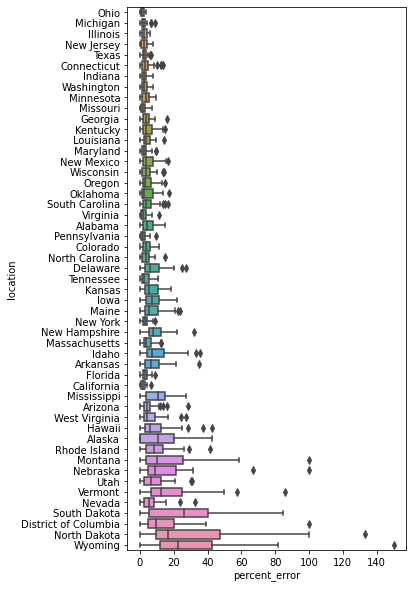

In [13]:
fig, ax = plt.subplots(figsize=(5,10))
m6_error = error_data[error_data.month_out == 6]
order = error_data.groupby('location').percent_error.mean().sort_values().index
sns.boxplot(
    x='percent_error',
    y='location',
    data=m6_error,
    order=order,
    ax=ax
)

## Summarize prediction error

In [14]:
stds = error_data.groupby(['location', 'month_out']).error.std()
abs_mean = error_data.groupby(['location', 'month_out']).error.apply(lambda x: np.mean(np.abs(x)))
mape = error_data.groupby(['location', 'month_out']).percent_error.apply(lambda x: np.mean(np.abs(x)))
std_pe = error_data.groupby(['location', 'month_out']).percent_error.std()
error_summary = pd.DataFrame(stds).rename(columns={'error': 'Std Error'}).reset_index().merge(
    pd.DataFrame(abs_mean).rename(columns={'error': 'Mean Absolute Error'}).reset_index()

).merge(
    pd.DataFrame(mape).rename(columns={'percent_error': 'Mean Absolute Percent Error'}).reset_index()
).merge(
    pd.DataFrame(std_pe).rename(columns={'percent_error': 'Std Percent Error'}).reset_index()
)
error_summary.to_csv('output/prediction_error_summary.csv', index=False)
error_summary

,location,month_out,Std Error,Mean Absolute Error,Mean Absolute Percent Error,Std Percent Error
0,Alabama,1,9.192989,10.979592,17.773053,13.186771
1,Alabama,2,4.115358,3.333333,5.310717,4.069034
2,Alabama,3,4.006932,3.234043,5.130241,3.914018
3,Alabama,4,4.050884,3.304348,5.241768,3.881029
4,Alabama,5,4.088911,3.333333,5.271106,3.919722
...,...,...,...,...,...,...
301,Wyoming,2,2.180644,1.677083,27.946636,28.337500
302,Wyoming,3,2.199886,1.691489,28.347822,28.505739
303,Wyoming,4,2.219615,1.706522,28.529296,28.793267
304,Wyoming,5,2.239848,1.722222,28.992340,28.944901
